### Parse `Franka Emika Panda` in MuJoCo

In [1]:
import os
import time
import cv2  # image plot
import glfw # opengl
import numpy as np
import mujoco_py
import matplotlib.pyplot as plt
from screeninfo import get_monitors # get monitor size
np.set_printoptions(precision=2)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Ready.


### MuJoCo parser class

In [2]:
class MuJoCoParserClass(object):
    def __init__(self,
                 name     = 'Robot',
                 xml_path = ''
                ):
        """
            Initialize MuJoCo parser
        """
        self.name        = name
        self.xml_path    = xml_path
        self.cwd         = os.getcwd()
        # Simulation
        self.tick         = 0
        self.VIEWER_EXIST = False
        # Parse the xml file
        self._parse_xml()
        # Reset
        self.reset()
        
    def _parse_xml(self):
        """
            Parse an xml file
        """
        # Basic MuJoCo model and sim
        self.full_xml_path = os.path.abspath(os.path.join(self.cwd,self.xml_path))
        self.model         = mujoco_py.load_model_from_path(self.full_xml_path)
        self.sim           = mujoco_py.MjSim(self.model)
        # Parse model information
        self.dt              = self.sim.model.opt.timestep 
        self.HZ              = int(1/self.dt)
        self.n_body          = self.model.nbody
        self.body_names      = list(self.sim.model.body_names)
        self.n_joint         = self.model.njnt
        self.joint_idxs      = np.arange(0,self.n_joint,1)
        self.joint_names     = [self.sim.model.joint_id2name(x) for x in range(self.n_joint)]
        self.joint_types     = self.sim.model.jnt_type # 0:free, 1:ball, 2:slide, 3:hinge
        self.joint_range     = self.sim.model.jnt_range
        self.actuator_names  = list(self.sim.model.actuator_names)
        self.n_actuator      = len(self.actuator_names)
        self.torque_range    = self.sim.model.actuator_ctrlrange
        self.rev_joint_idxs  = np.where(self.joint_types==3)[0].astype(np.int32) # revolute joint indices
        self.rev_joint_names = [self.joint_names[x] for x in self.rev_joint_idxs]
        self.n_rev_joint     = len(self.rev_joint_idxs)
        self.rev_qvel_idxs   = [self.sim.model.get_joint_qvel_addr(x) for x in self.rev_joint_names]
        self.geom_names      = list(self.sim.model.geom_names)
        self.n_geom          = len(self.geom_names)
        
    def print_env_info(self):
        """
            Print env info
        """
        print ("[%s] Instantiated from [%s]"%(self.name,self.full_xml_path))
        print ("- Simulation timestep is [%.4f]sec and frequency is [%d]HZ"%(self.dt,self.HZ))
        print ("- [%s] has [%d] bodies"%(self.name,self.n_body))
        for b_idx in range(self.n_body):
            body_name  = self.body_names[b_idx]
            print (" [%02d] body name:[%s]"%(b_idx,body_name))
        print ("- [%s] has [%d] joints"%(self.name,self.n_joint))
        for j_idx in range(self.n_joint):
            joint_name = self.joint_names[j_idx]
            joint_type = self.joint_types[j_idx]
            if joint_type == 0:
                joint_type_str = 'free'
            elif joint_type == 1:
                joint_type_str = 'ball'
            elif joint_type == 2:
                joint_type_str = 'prismatic'
            elif joint_type == 3:
                joint_type_str = 'revolute'
            else:
                joint_type_str = 'unknown'
            print (" [%02d] name:[%s] type:[%s] joint range:[%.2f to %.2f]"%
                (j_idx,joint_name,joint_type_str,self.joint_range[j_idx,0],self.joint_range[j_idx,1]))
        print ("- [%s] has [%d] revolute joints"%(self.name,self.n_rev_joint))
        for j_idx in range(self.n_rev_joint):
            rev_joint_idx  = self.rev_joint_idxs[j_idx]
            rev_joint_name = self.rev_joint_names[j_idx]
            print (" [%02d] joint index:[%d] and name:[%s]"%(j_idx,rev_joint_idx,rev_joint_name))
        print  ("- [%s] has [%d] actuators"%(self.name,self.n_actuator))
        for a_idx in range(self.n_actuator):
            actuator_name = self.actuator_names[a_idx]
            print (" [%02d] actuator name:[%s] torque range:[%.2f to %.2f]"%
            (a_idx,actuator_name,self.torque_range[a_idx,0],self.torque_range[a_idx,1]))
        print  ("- [%s] has [%d] geometries"%(self.name,self.n_geom))
        for g_idx in range(self.n_geom):
            geom_name = self.geom_names[g_idx]
            print (" [%02d] geometry name:[%s]"%(g_idx,geom_name))
            
    def plot_scene(self,
                   figsize       = (12,8),
                   render_w      = 1200,
                   render_h      = 800,
                   title_str     = None,
                   title_fs      = 10,
                   cam_distance  = None,
                   cam_elevation = None,
                   cam_lookat    = None,
                   RETURN_IMG    = False):
        """
            Plot scene
        """
        self.init_viewer()
        N_TRY = 5
        for _ in range(N_TRY): # render multiple times to properly apply plot configurations
            for r_idx in range(len(self.sim.render_contexts)):
                if cam_distance is not None:
                    self.sim.render_contexts[r_idx].cam.distance  = cam_distance
                if cam_elevation is not None:
                    self.sim.render_contexts[r_idx].cam.elevation = cam_elevation
                if cam_lookat is not None:
                    self.sim.render_contexts[r_idx].cam.lookat[0] = cam_lookat[0]
                    self.sim.render_contexts[r_idx].cam.lookat[1] = cam_lookat[1]
                    self.sim.render_contexts[r_idx].cam.lookat[2] = cam_lookat[2]
            img = self.sim.render(width=render_w,height=render_h)
        img = cv2.flip(cv2.rotate(img,cv2.ROTATE_180),1) # 0:up<->down, 1:left<->right
        if RETURN_IMG: # return RGB image
            return img
        else: # plot image
            plt.figure(figsize=figsize)
            plt.imshow(img)
            if title_str is not None:
                plt.title(title_str,fontsize=title_fs)
            plt.axis('off')
            plt.show()
            
    def reset(self,RESET_GLFW=False):
        """
             Reset simulation
        """
        self.tick = 0
        self.sim.reset()
            
    def init_viewer(self,
                    window_width  = None,
                    window_height = None):
        """
            Initialize viewer
        """
        if not self.VIEWER_EXIST:
            self.VIEWER_EXIST = True
            self.viewer = mujoco_py.MjViewer(self.sim) # this will make a new window
        # Set viewer
        if (window_width is not None) and (window_height is not None):
            self.set_viewer(window_width=window_width,window_height=window_height)
            
    def set_viewer(self,
                   window_width    = 0.5,
                   window_height   = 0.5):
        """
            Set viewer
        """
        if self.VIEWER_EXIST:
            self.window = self.viewer.window
            width  = int(window_width*get_monitors()[0].width)
            height = int(window_height*get_monitors()[0].height)
            glfw.set_window_size(window=self.window,width=width,height=height)
            
    def terminate_viewer(self):
        """
            Terminate viewer
        """
        if self.VIEWER_EXIST:
            self.VIEWER_EXIST = False 
            self.viewer.render() # render once before terminate
            time.sleep(1.0)
            glfw.terminate() # terminate
            time.sleep(1.0) 
            glfw.init() # initialize once

    def step(self):
        """
            Step simulation
        """
        self.tick = self.tick + 1
        # Forward dynamics
        self.sim.step()

    def render(self):
        """
            Render simulation
        """
        self.viewer.render()
        
        
        
print ("Ready.")        

Ready.


### Parse

In [3]:
env = MuJoCoParserClass(name='Panda',xml_path='../asset/panda/franka_panda.xml')
env.print_env_info()
print ("Done.")

[Panda] Instantiated from [/Users/sj/Dropbox/Mac/Implementation/little-complex-mujoco-usage/asset/panda/franka_panda.xml]
- Simulation timestep is [0.0020]sec and frequency is [500]HZ
- [Panda] has [18] bodies
 [00] body name:[world]
 [01] body name:[panda_base]
 [02] body name:[panda_pedestal]
 [03] body name:[panda_link_0]
 [04] body name:[panda_link_1]
 [05] body name:[panda_link_2]
 [06] body name:[panda_link_3]
 [07] body name:[panda_link_4]
 [08] body name:[panda_link_5]
 [09] body name:[panda_link_6]
 [10] body name:[panda_link_7]
 [11] body name:[right_hand]
 [12] body name:[panda_right_gripper]
 [13] body name:[panda_eef]
 [14] body name:[panda_leftfinger]
 [15] body name:[panda_finger_joint1_tip]
 [16] body name:[panda_rightfinger]
 [17] body name:[panda_finger_joint2_tip]
- [Panda] has [9] joints
 [00] name:[panda_joint1] type:[revolute] joint range:[-2.90 to 2.90]
 [01] name:[panda_joint2] type:[revolute] joint range:[-1.76 to 1.76]
 [02] name:[panda_joint3] type:[revolute]

### Plot

Creating window glfw
Creating offscreen glfw


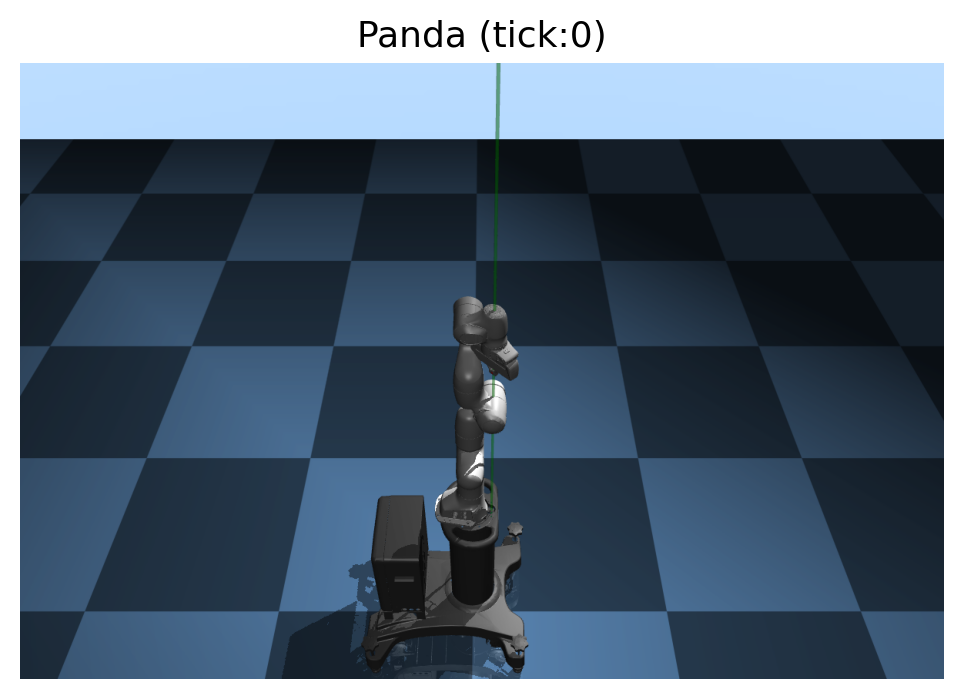

In [4]:
env.plot_scene(figsize=(8,4),title_str='Panda (tick:%d)'%(env.tick),title_fs=13)

### Animate

In [5]:
env.init_viewer(window_width=0.4,window_height=0.4)
env.reset()
while env.tick <= 2000:
    env.step()
    env.render()
print ("Done.")

Done.


### Plot again

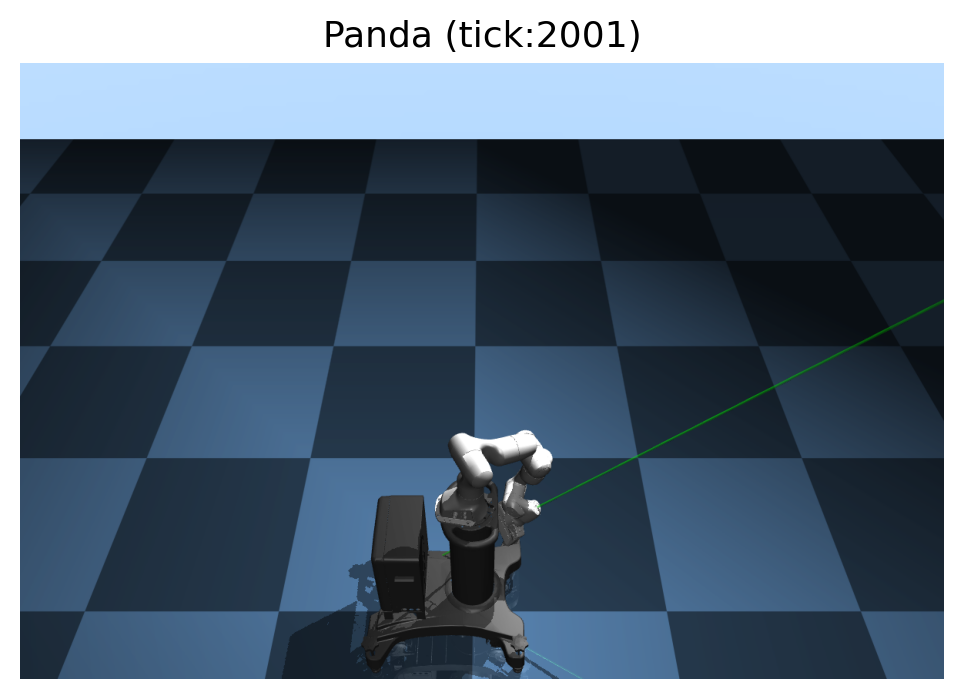

In [6]:
env.plot_scene(figsize=(8,4),title_str='Panda (tick:%d)'%(env.tick),title_fs=13)

### Terminate viewer

In [7]:
env.terminate_viewer()